Import necessary libraries

In [ ]:
import torch
import torchvision.transforms as transforms
from torchvision import models
import numpy as np
import cv2
import requests
from PIL import Image
import matplotlib.pyplot as plt

Load Lion Image from URL

In [ ]:
# Load Lion Image from URL
import requests
from PIL import Image
import io

# Image URL
lion_url = "https://upload.wikimedia.org/wikipedia/commons/8/82/Cat_Eyes.jpg"

# Custom Headers
headers = {"User-Agent": "Mozilla/5.0"}

# Fetch Image with Headers
response = requests.get(lion_url, headers=headers, stream=True)

# Check if the request was successful
if response.status_code == 200:
    try:
        lion_image = Image.open(io.BytesIO(response.content)).convert('RGB')
        lion_image.show()  # Display the image
    except Exception as e:
        print("Error loading image:", e)
else:
    print("Failed to fetch image. Status code:", response.status_code)


# Preprocess Image for VGG16
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
input_tensor = transform(lion_image).unsqueeze(0)  # Add batch dimension
input_tensor.requires_grad = True  # Ensure gradients can be computed

Load Pre-trained VGG16 Model

In [ ]:
# Load Pre-trained VGG16 Model
model = models.vgg16(pretrained=True)
model.eval()

# Forward Pass
output = model(input_tensor)
target_class = output.argmax().item()

Visualization of Standard Backpropagation and Guided Backpropagation

Standard Backpropagation:

    - Compute the gradient of the output with respect to the input image
    - Highlights **both positive and negative influences** of input pixels
    - Formula: dL/dx = dL/dy * dy/dx, where L is the loss, y is the output, and x is the input


Guided Backpropagation:

    - A variant of backpropagation that **removes negative gradients**
    - Ensures only **positive influences** are visualized
    - Formula:
          g^l = g^(l+1), if x^l > 0 and g^(l+1) > 0
          g^l = 0, otherwise
          where g^l is the gradient at layer l, and x^l is the activation

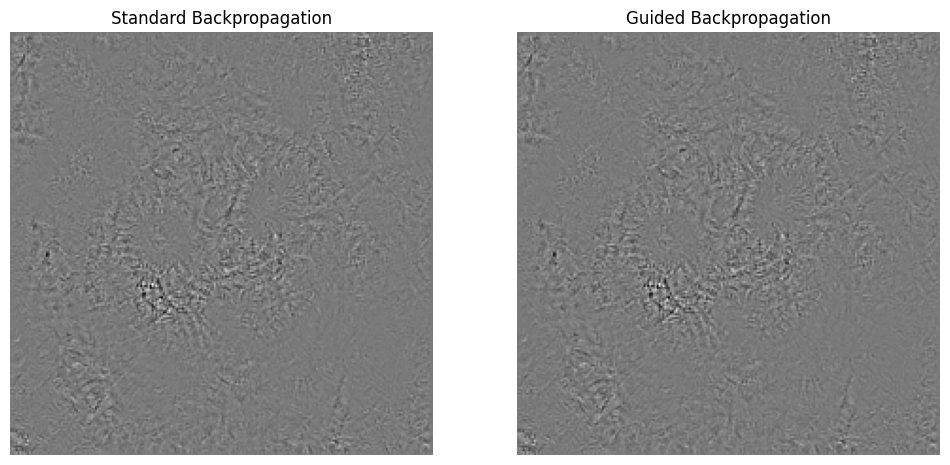

In [ ]:
### 1️⃣ Standard Backpropagation ###
model.zero_grad()
output[0, target_class].backward(retain_graph=True)  # Retain the graph
gradients = input_tensor.grad.data.squeeze().numpy()

# Normalize Gradients for Visualization
grad_gray = np.mean(gradients, axis=0)
grad_gray = (grad_gray - grad_gray.min()) / (grad_gray.max() - grad_gray.min())

### 2️⃣ Guided Backpropagation ###
class GuidedBackpropReLU(torch.autograd.Function):
    @staticmethod
    def forward(ctx, input):
        ctx.save_for_backward(input)
        return input.clamp(min=0)  # Normal ReLU: Blocks negative values

    @staticmethod
    def backward(ctx, grad_output):
        input, = ctx.saved_tensors
        grad_input = grad_output.clone()
        grad_input[input < 0] = 0  # Block negative gradients
        return grad_input

# Replace all ReLU layers with Guided Backpropagation ReLU
for module in model.modules():
    if isinstance(module, torch.nn.ReLU):
        module.register_forward_hook(lambda m, inp, out: GuidedBackpropReLU.apply(inp[0]))

# Zero gradients & Compute GBP
model.zero_grad()
input_tensor.grad = None  # Reset gradients
output[0, target_class].backward()  # No need for retain_graph=True now

# Extract GBP Gradients
gbp_gradients = input_tensor.grad.data.squeeze().numpy()
gbp_gray = np.mean(gbp_gradients, axis=0)
gbp_gray = (gbp_gray - gbp_gray.min()) / (gbp_gray.max() - gbp_gray.min())

# Plot Both Visualizations
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

axes[0].imshow(grad_gray, cmap="gray")
axes[0].set_title("Standard Backpropagation")
axes[0].axis("off")

axes[1].imshow(gbp_gray, cmap="gray")
axes[1].set_title("Guided Backpropagation")
axes[1].axis("off")

plt.show()

Summary of the Code: Finding Influence of Input Pixels using Backpropagation and Guided Backpropagation

    This code visualizes the influence of individual pixels on a CNN’s decision using Standard Backpropagation and Guided Backpropagation.
    It highlights which parts of an image contribute the most to a neural network's classification decision.

Outcome:

    Standard Backpropagation produces noisy activation maps.

    Guided Backpropagation provides more localized and interpretable feature maps.

    Helps understand how CNNs make decisions by visualizing key pixels.